In [ ]:
import pandas as pd

**Load the dataset**

In [ ]:
df = pd.read_csv('healthcare_dataset.csv')
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,31-01-2024,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,02-02-2024,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,20-08-2019,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,26-08-2019,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,22-09-2022,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,07-10-2022,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,18-11-2020,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78241,450,Elective,18-12-2020,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,19-09-2022,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,09-10-2022,Penicillin,Abnormal


**Clean the data**

In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

#**Feature Engineering**

**Add useful features (length of stay, risk score, age group)**

In [ ]:
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], dayfirst=True)
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], dayfirst=True)
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

risk_map = {'Cancer':3,'Diabetes':2,'Obesity':1}
df['Risk Score'] = df['Medical Condition'].map(risk_map).fillna(0)


df['Age Group'] = pd.cut(df['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['Child', 'Young Adult', 'Adult', 'Senior', 'Elder'])

In [ ]:

df = df.drop(['Name', 'Room Number', 'Doctor', 'Hospital', 'Date of Admission', 'Discharge Date'], axis=1)


**Convert text data into numbers**

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# Convert multiple-choice columns to dummy variables
df = pd.get_dummies(df, columns=[
    'Blood Type', 'Medical Condition', 'Insurance Provider',
    'Admission Type', 'Medication', 'Age Group'
])

In [ ]:
# STEP 8: Normalize numerical values
scaler = StandardScaler()
df[['Age', 'Length of Stay', 'Risk Score']] = scaler.fit_transform(df[['Age', 'Length of Stay', 'Risk Score']])

#**Feature Selection**

**Splitting of Data**

In [ ]:
X = df.drop('Billing Amount',axis = 1) #feature
y = df['Billing Amount'] #target

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

selector = SelectKBest(score_func = f_regression, k=20)
X_selected = selector.fit_transform(X, y)
X = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

#**Train - Test Split**

**Split data into Train, Validation, and Test**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


#**Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)


In [ ]:
# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from numpy import round as np_round

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" MAE: ₹{np_round(mae, 2)}")
print(f" MSE: ₹{np_round(mse, 2)}")
print(f" R² Score: {np_round(r2, 4)}")


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 MAE: ₹12285.11
 MSE: ₹202048037.1
 R² Score: -0.0028


In [ ]:
# Predict billing amount for a new patient (example)
sample_patient = X_test.iloc[[0]]
predicted_amount = model.predict(sample_patient)[0][0]
print(f"Predicted Billing Amount: ₹{np_round(predicted_amount, 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Billing Amount: ₹26976.109375


#**Visualization**

In [ ]:
# Train the model and store training history
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 203341248.0000 - mean_absolute_error: 12334.9678 - val_loss: 202917760.0000 - val_mean_absolute_error: 12323.9229
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 203324576.0000 - mean_absolute_error: 12335.3672 - val_loss: 203060208.0000 - val_mean_absolute_error: 12322.0000
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 203558096.0000 - mean_absolute_error: 12337.3643 - val_loss: 202908032.0000 - val_mean_absolute_error: 12326.0234
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 201763792.0000 - mean_absolute_error: 12271.1006 - val_loss: 202799056.0000 - val_mean_absolute_error: 12322.9551
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 201911952.0000 - mean_absolute_error: 12292.0918 - val_loss: 202982944.0000 - val_mean_absolute_error: 12329.5068
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 203126480.0000 - mean_absolute_error: 12344.2207 - val_los

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 201012048.0000 - mean_absolute_error: 12273.8604 - val_loss: 202615120.0000 - val_mean_absolute_error: 12321.4268
Epoch 2/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 201242144.0000 - mean_absolute_error: 12256.1367 - val_loss: 202583888.0000 - val_mean_absolute_error: 12321.1689
Epoch 3/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 201736320.0000 - mean_absolute_error: 12281.8828 - val_loss: 202671312.0000 - val_mean_absolute_error: 12318.3076
Epoch 4/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 202238048.0000 - mean_absolute_error: 12306.2354 - val_loss: 202628912.0000 - val_mean_absolute_error: 12319.6152
Epoch 5/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 200538832.0000 - mean_absolute_error: 12225.9355 - val_loss: 202565296.0000 - val_mean_absolute_error: 12319.1348
Epoch 6/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 202280192.0000 - mean_absolute_error: 12319.6377 - val_los

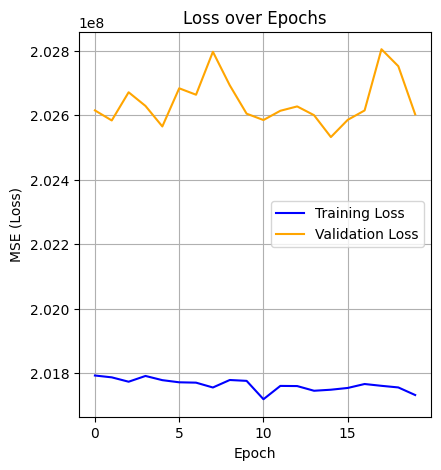

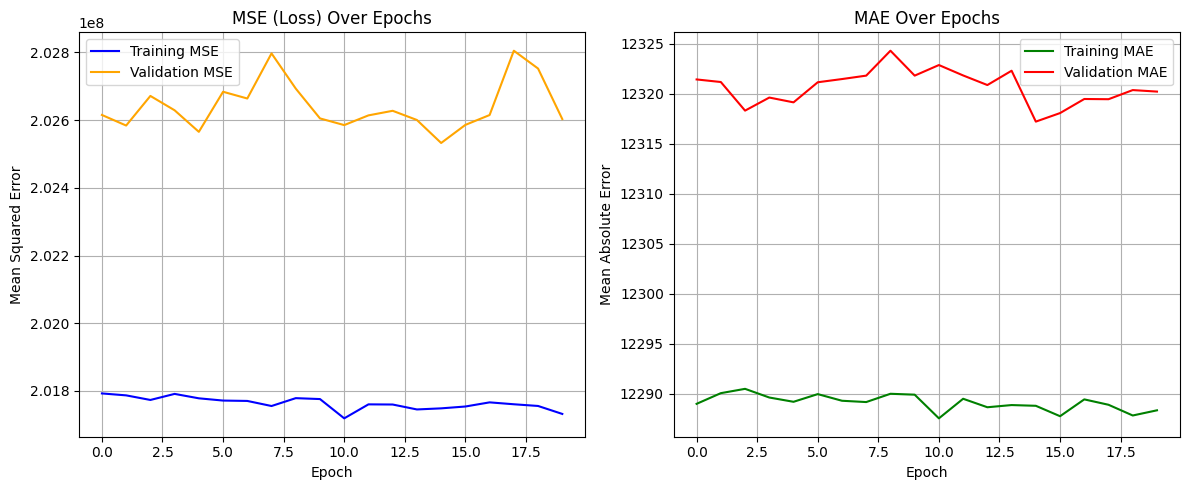

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))

# 🔷 Loss (Mean Squared Error)
plt.subplot(1, 2,2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE (Loss)')
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 5))


# 🔹 MSE = loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training MSE', color='blue')
plt.plot(history.history['val_loss'], label='Validation MSE', color='orange')
plt.title('MSE (Loss) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# 🔹 MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='green')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
